In [34]:
# Loading neccesary packages
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from datetime import timedelta

In [35]:
airbnb_raw = pd.read_csv('Jan2019-Feb2020_cleaned_data.csv')
airbnb_raw.head()

listing_id  host_id last_scraped  experience host_response_time  \
0        2539     2787   2019-01-09        3776     within an hour   
1        2595     2845   2019-01-09        3774       within a day   
2        3330     4177   2019-01-09        3713       within a day   
3        5238     7549   2019-01-09        3623       within a day   
4        5295     7702   2019-01-09        3620       within a day   

   host_response_rate  host_is_superhost  host_total_listings_count  \
0                 100               True                        8.0   
1                  60              False                        5.0   
2                 100              False                        4.0   
3                  92               True                        4.0   
4                  92              False                        1.0   

   host_identity_verified  calculated_host_listings_count  ...  \
0                    True                               8  ...   
1                    True                               2  ...   
2                    True                               3  ...   
3                    True                               4  ...   
4                    True                               1  ...   

   number_of_reviews  reviews_per_month  number_of_reviews_ltm  \
0                  9               0.24                      2   
1                 43               0.39                     14   
2                 39               0.36                     12   
3                152               1.33                      8   
4                 43               0.37                      6   

  review_scores_rating review_scores_accuracy review_scores_cleanliness  \
0                 98.0                   10.0                      10.0   
1                 95.0                    9.0                       9.0   
2                 97.0                   10.0                      10.0   
3                 93.0                    9.0                       9.0   
4                 94.0                   10.0                       9.0   

  review_scores_checkin  review_scores_communication  review_scores_location  \
0                  10.0                         10.0                    10.0   
1                  10.0                         10.0                    10.0   
2                  10.0                         10.0                    10.0   
3                  10.0                         10.0                     9.0   
4                  10.0                         10.0                     9.0   

   review_scores_value  
0                 10.0  
1                  9.0  
2                 10.0  
3                  9.0  
4                  9.0  

[5 rows x 54 columns]

In [36]:
print(len(airbnb_raw.index))
print(airbnb_raw.columns)

244905
Index(['listing_id', 'host_id', 'last_scraped', 'experience',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_identity_verified',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'neighbourhood',
       'borough', 'property_type', 'room_type', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities_count', 'is_wifi', 'is_kitchen',
       'is_heating', 'is_smoke_detector', 'is_aircon', 'price',
       'security_deposit', 'cleaning_fee', 'price_for_extra_people',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'is_instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'requ

In [37]:
print('The initial size of the dataset: ',airbnb_raw.size)
airbnb_raw.info()

The initial size of the dataset:  13224870
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244905 entries, 0 to 244904
Data columns (total 54 columns):
listing_id                                      244905 non-null int64
host_id                                         244905 non-null int64
last_scraped                                    244905 non-null object
experience                                      244905 non-null int64
host_response_time                              244905 non-null object
host_response_rate                              244905 non-null int64
host_is_superhost                               244905 non-null bool
host_total_listings_count                       244905 non-null float64
host_identity_verified                          244905 non-null bool
calculated_host_listings_count                  244905 non-null int64
calculated_host_listings_count_entire_homes     244905 non-null int64
calculated_host_listings_count_private_rooms    244905 non-null int64
calc

In [38]:
#Drop rows with price equal to 0
airbnb_raw = airbnb_raw[airbnb_raw['price']!=0]

In [39]:
#Function to convert dates efficiently
def lookup(s):
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [40]:
airbnb_raw['last_scraped'] = lookup(airbnb_raw['last_scraped'])

In [41]:
print(airbnb_raw['last_scraped'].head())

0   2019-01-09
1   2019-01-09
2   2019-01-09
3   2019-01-09
4   2019-01-09
Name: last_scraped, dtype: datetime64[ns]


In [42]:
airbnb_raw['year'] = airbnb_raw['last_scraped'].dt.year
airbnb_raw['month'] = airbnb_raw['last_scraped'].dt.month
airbnb_raw['day'] = airbnb_raw['last_scraped'].dt.day
airbnb_raw['month_pad'] = airbnb_raw['month'].apply(lambda x : format(x, '02'))
airbnb_raw['yearmonth'] = airbnb_raw['year'].astype(str) + "-" + airbnb_raw['month_pad'].astype(str)

In [43]:
#Number of unique room ids per month to check for homogeneity across observed months
airbnb_raw.groupby(['yearmonth'])['listing_id'].nunique()

yearmonth
2019-01    13982
2019-02    13691
2019-03    17543
2019-04    17330
2019-05    17669
2019-06    17786
2019-07    18020
2019-08    17996
2019-09    18047
2019-10    18305
2019-11    18339
2019-12    18597
2020-01    19041
2020-02    18439
Name: listing_id, dtype: int64

## Adding additional features
1. Weather data
2. Holidays data 
  1. Function *holidays_soon_n_week* can be used to calculate how many holidays from holidays_time dataset will be in coming N weeks for specific date
3. Seasonalisy as dummy variables 

In [44]:
#Add weather data to airbnb_raw dataset
#TAV - average daily temp, TAV_Month - avarage monthly temp
#TDIFF - max difference daily, TDIFF_Month - max difference monthly
#Weather_type - cold/hot/mild and etc.
#TSNOW_Month - total amoint of snow this month

weather = pd.read_excel("weather_output.xlsx")
weather = weather.rename(columns={"DATE": "last_scraped"}) 
weather['last_scraped'] = lookup(weather['last_scraped'])

weather_use = weather[['last_scraped','TAV','TAV_Month','TDIFF','TDIFF_Month', 'Weather_type', 'TSNOW_Month']]
airbnb_raw = pd.merge(airbnb_raw,weather_use,on=['last_scraped'])

In [45]:
#import holidays set 

us_holidays = holidays.UnitedStates(state='NY', years=[2019, 2020])
holiday_names = []
holiday_dates = []
for holiday in list(us_holidays.items()):
    holiday_dates.append(holiday[0])
    holiday_names.append(holiday[1])
    
holidays_time = pd.DataFrame({
    'holiday': holiday_names,
    'ds': holiday_dates,
})

holidays_time['ds'] = lookup(holidays_time['ds'])

In [46]:
#function that defines how many holidays are in coming N weeks for specific date
def holidays_soon_n_week(date, n):
    s = 0
    delta = timedelta(days = n*7)
    for j in range(0, len(holidays_time)):
        if (holidays_time['ds'].iloc[j] > date) & (holidays_time['ds'].iloc[j] <= (date + delta)):
            s = s + 1
        j = j + 1
    return s

In [47]:
#save unique dates from airbnb listings to separate dataset
dates_raw = pd.DataFrame()
dates_raw['last_scraped'] = airbnb_raw['last_scraped'].unique()

#loop to create column with Number of holidays for each date in column 
dates_raw['holidays'] = ''
for i in range(0,len(dates_raw)):
    dates_raw['holidays'].iloc[i] = holidays_soon_n_week(dates_raw['last_scraped'].iloc[i],4)
    i = i + 1

In [48]:
airbnb_raw = pd.merge(airbnb_raw,dates_raw,on=['last_scraped'])

In [49]:
#seasonality

months = airbnb_raw['month'].unique()
seasons = ['Winter','Winter','Spring','Spring','Spring','Summer','Summer','Summer','Autumn','Autumn','Autumn','Winter']
month_season = pd.DataFrame({
    'month': months,
    'season': seasons
})

month_season = pd.get_dummies(month_season)

In [50]:
airbnb_raw = pd.merge(airbnb_raw,month_season,on=['month'])

In [60]:
pd.options.display.max_columns = None
airbnb_raw.head()

listing_id  host_id last_scraped  experience  host_response_rate  \
0        2539     2787   2019-01-09        3776                 100   
1        2595     2845   2019-01-09        3774                  60   
2        3330     4177   2019-01-09        3713                 100   
3        5238     7549   2019-01-09        3623                  92   
4        5295     7702   2019-01-09        3620                  92   

   host_is_superhost  host_total_listings_count  host_identity_verified  \
0                  1                        8.0                    True   
1                  0                        5.0                    True   
2                  0                        4.0                    True   
3                  1                        4.0                    True   
4                  0                        1.0                    True   

   calculated_host_listings_count  \
0                               8   
1                               2   
2                               3   
3                               4   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            0   
1                                            1   
2                                            0   
3                                            2   
4                                            1   

   calculated_host_listings_count_private_rooms  \
0                                             5   
1                                             0   
2                                             3   
3                                             0   
4                                             0   

   calculated_host_listings_count_shared_rooms    neighbourhood property_type  \
0                                            3       Kensington     Apartment   
1                                            1          Midtown     Apartment   
2                                            0     Williamsburg     Apartment   
3                                            2        Chinatown     Apartment   
4                                            0  Upper West Side     Apartment   

   bathrooms  bedrooms  beds  bed_type  amenities_count  is_wifi  is_kitchen  \
0        1.0       1.0   1.0  Real Bed               44        1           1   
1        1.0       0.0   1.0  Real Bed               36        1           1   
2        1.0       1.0   1.0  Real Bed               25        1           1   
3        1.0       1.0   2.0  Real Bed               27        1           1   
4        1.0       1.0   1.0  Real Bed               21        1           1   

   is_heating  is_smoke_detector  is_aircon  price  security_deposit  \
0           1                  1          0  149.0             100.0   
1           1                  1          1  225.0             350.0   
2           1                  1          0   70.0             150.0   
3           1                  1          1  150.0               0.0   
4           1                  1          1  135.0             450.0   

   cleaning_fee  price_for_extra_people  guests_included  minimum_nights  \
0          25.0                    25.0                1               1   
1         100.0                     0.0                2               1   
2         125.0                    50.0                2               5   
3          40.0                    10.0                2               1   
4          75.0                     0.0                1               5   

   maximum_nights  has_availability  availability_30  availability_60  \
0             730                 1               30               60   
1            1125                 1               30               60   
2             730                 1                1               10   
3            1125                 1               13               26   
4             365                 1               11               29  

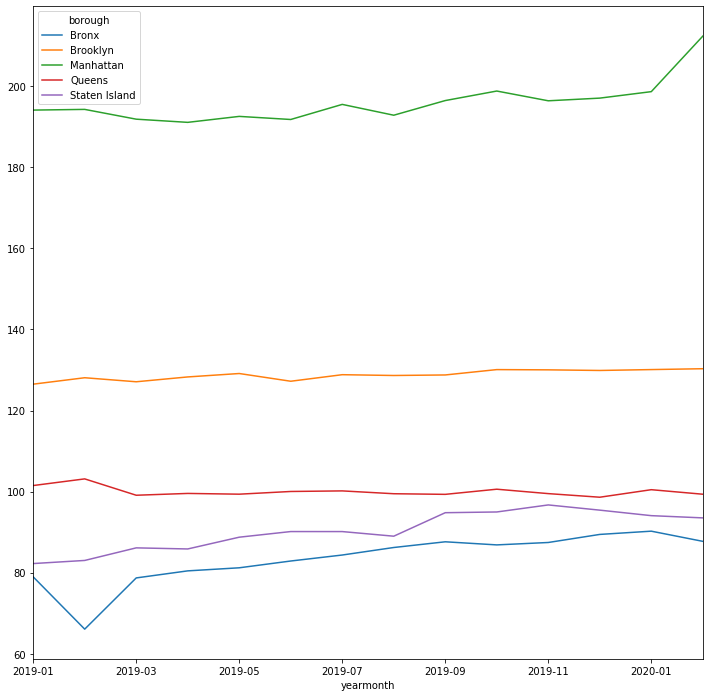

In [53]:
#Development in average price per month per borough
fig, ax = plt.subplots(figsize=(12,12))
airbnb_raw.groupby(['yearmonth','borough']).mean()['price'].unstack().plot(ax=ax)

In [54]:
#Convert boolean values into 0/1
def get_binary(x):
    if x is True:
        return 1
    else: 
        return 0

airbnb_raw['has_availability'] = airbnb_raw['has_availability'].apply(lambda x: get_binary(x))
airbnb_raw['is_instant_bookable'] = airbnb_raw['is_instant_bookable'].apply(lambda x: get_binary(x))
airbnb_raw['is_business_travel_ready'] = airbnb_raw['is_business_travel_ready'].apply(lambda x: get_binary(x))
airbnb_raw['is_wifi'] = airbnb_raw['is_wifi'].apply(lambda x: get_binary(x))
airbnb_raw['is_kitchen'] = airbnb_raw['is_kitchen'].apply(lambda x: get_binary(x))
airbnb_raw['is_heating'] = airbnb_raw['is_heating'].apply(lambda x: get_binary(x))
airbnb_raw['is_smoke_detector'] = airbnb_raw['is_smoke_detector'].apply(lambda x: get_binary(x))
airbnb_raw['is_aircon'] = airbnb_raw['is_aircon'].apply(lambda x: get_binary(x))
airbnb_raw['host_is_superhost'] = airbnb_raw['host_is_superhost'].apply(lambda x: get_binary(x))

In [55]:
#converting neighborhood and borough into values
# print(airbnb_raw['neighbourhood'].unique())
# print(airbnb_raw['borough'].unique())
airbnb_raw['cat_neighbourhood'] = airbnb_raw['neighbourhood'].astype('category').cat.codes
airbnb_raw['cat_property_type'] = airbnb_raw['property_type'].astype('category').cat.codes
airbnb_raw['cat_weather_type'] = airbnb_raw['Weather_type'].astype('category').cat.codes

airbnb_raw = pd.concat((airbnb_raw, pd.get_dummies(airbnb_raw['borough'], drop_first=True)), axis=1)
airbnb_raw = pd.concat((airbnb_raw, pd.get_dummies(airbnb_raw['cancellation_policy'], drop_first=True)), axis=1)
airbnb_raw = pd.concat((airbnb_raw, pd.get_dummies(airbnb_raw['host_response_time'], drop_first=True)), axis=1)
airbnb_raw = pd.concat((airbnb_raw, pd.get_dummies(airbnb_raw['room_type'], drop_first=True)), axis=1)

airbnb_raw = airbnb_raw.drop(['borough', 'cancellation_policy', 'host_response_time', 'room_type'], axis=1)

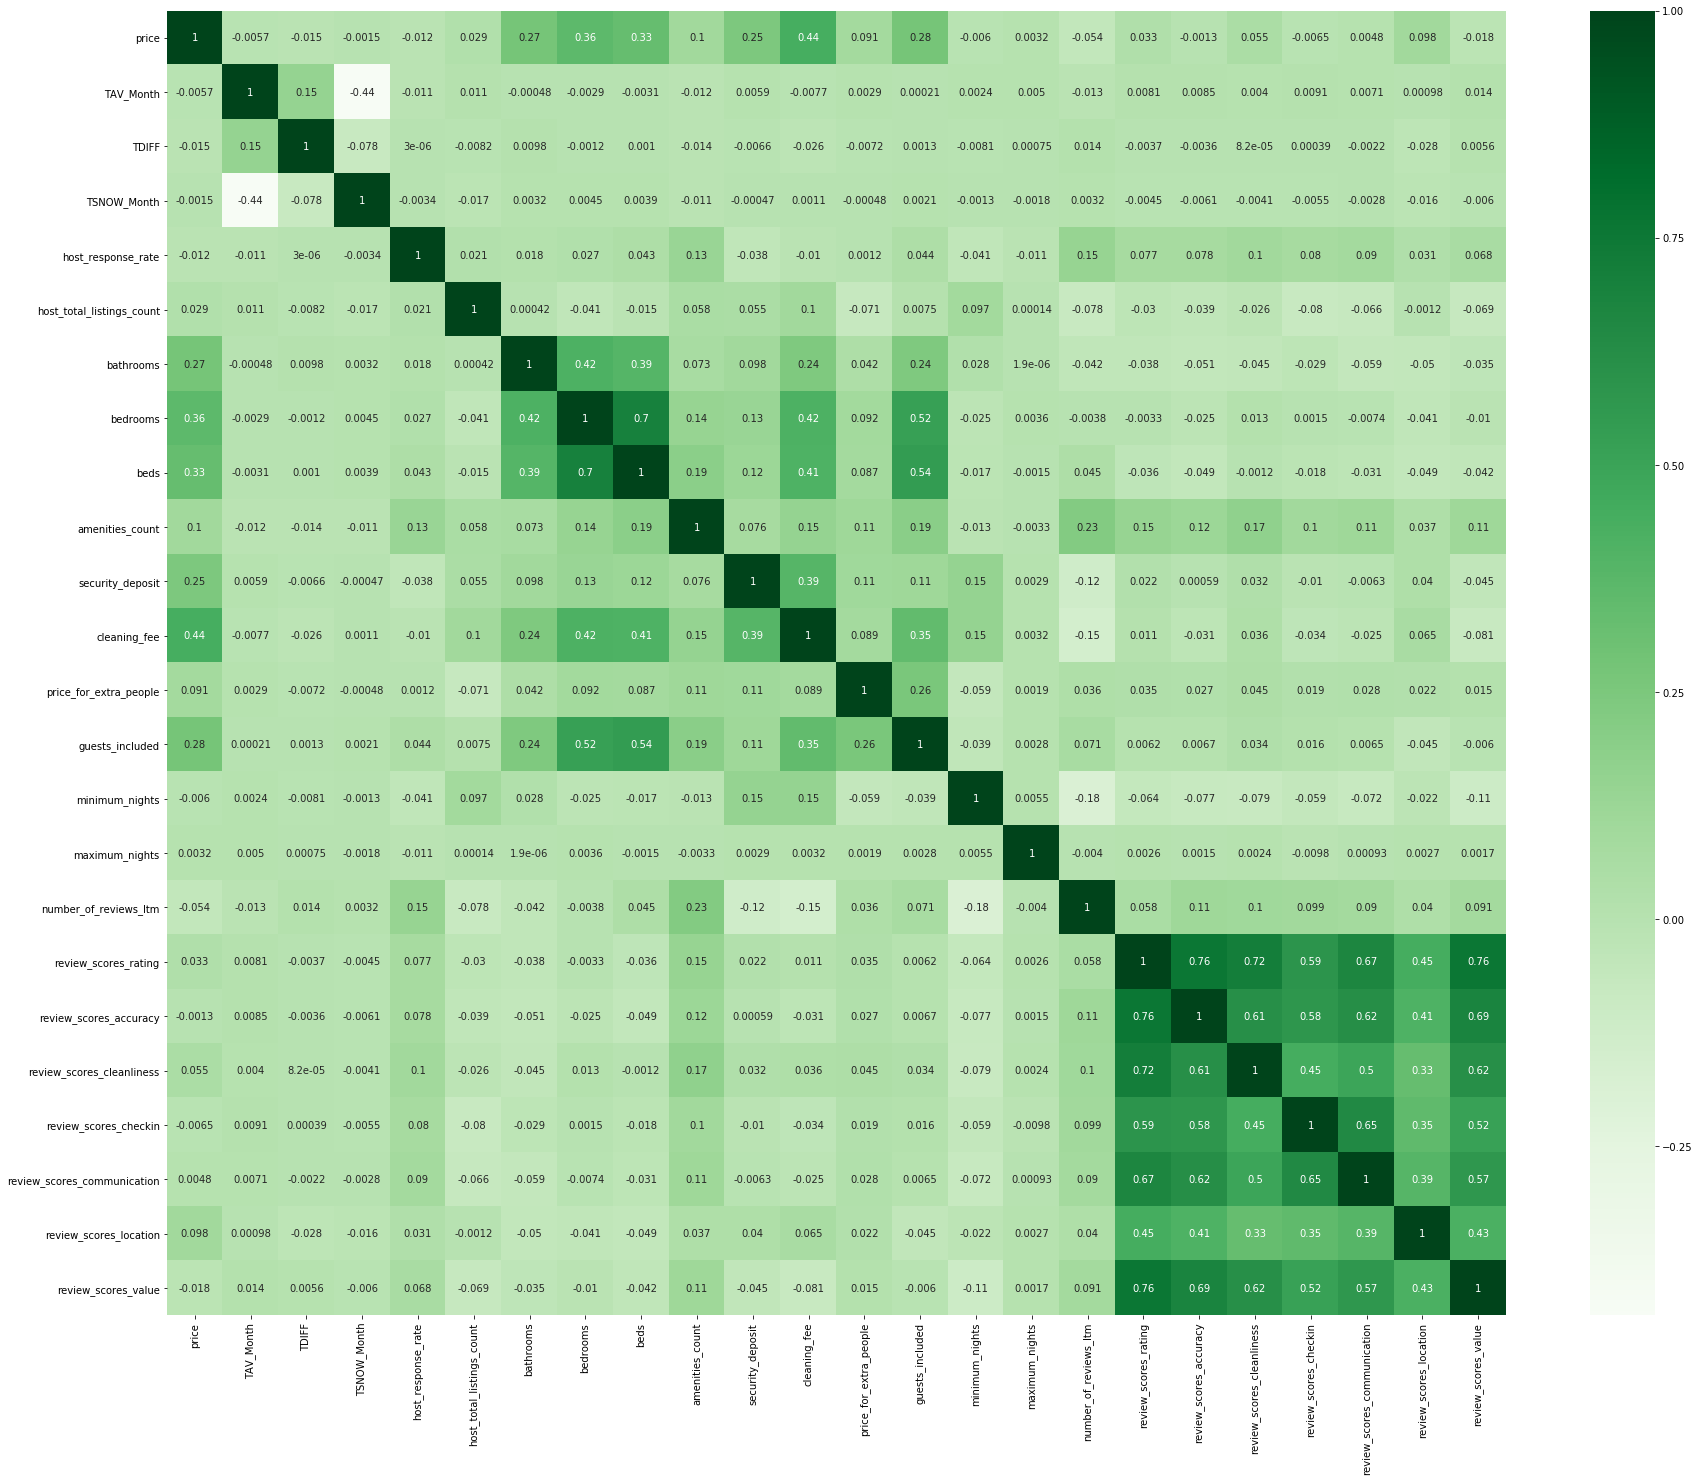

In [56]:
#Correlation matrix for relevant columns 
imp_cols = "price, TAV_Month, TDIFF, TSNOW_Month, host_response_rate,host_total_listings_count,bathrooms,bedrooms,beds, amenities_count, security_deposit, cleaning_fee, price_for_extra_people, guests_included, minimum_nights, maximum_nights, number_of_reviews_ltm, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value"
imp_cols = imp_cols.replace(" ","")
cols = imp_cols.split(",")

corrmat = airbnb_raw[cols].corr()
f, ax = plt.subplots(figsize=(30,24))
sns.heatmap(corrmat, annot=True, cmap = 'Greens')

# Fix box height
b, t = plt.ylim()
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) 
plt.savefig('Correlation_matrix.png', dpi=300)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.show()

['price', 'TAV_Month', 'TDIFF', 'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'price_for_extra_people', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
17


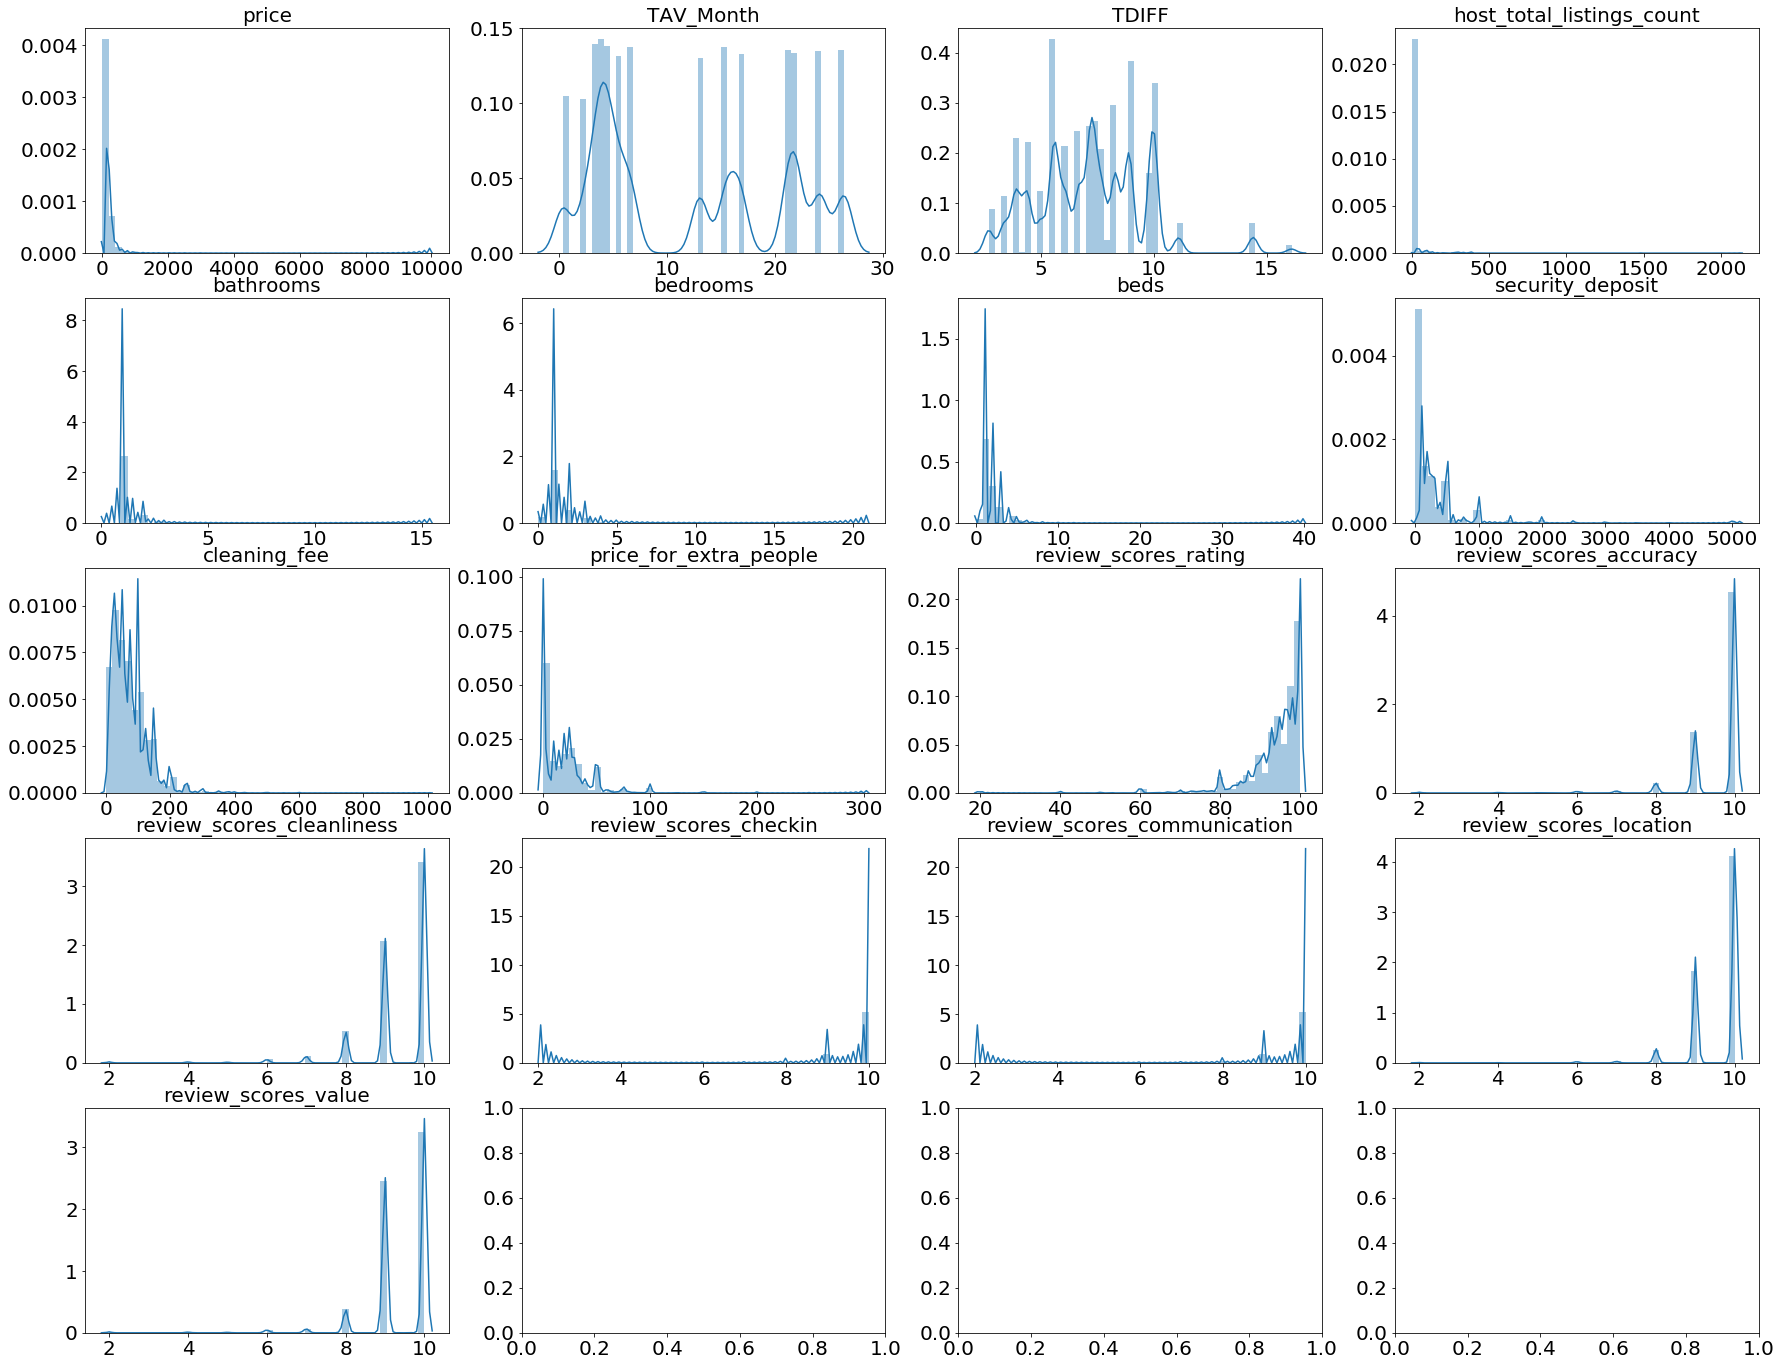

In [57]:
#Distribution plots 

def is_float(colu):
    col = airbnb_raw[colu]
    for item in col:
        if isinstance(item,float):
            return True
        else:
            return False

print([i for i in airbnb_raw[cols] if is_float(i)])
airbnb_raw_f = airbnb_raw[[i for i in airbnb_raw[cols] if is_float(i)]]
print(len(airbnb_raw_f.columns))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(30,24))
for i, column in enumerate(airbnb_raw_f.columns):
    b = sns.distplot(airbnb_raw_f[column],ax=axes[i//4,i%4], axlabel=False)
    b.axes.set_title(column, fontsize=20)
plt.savefig('distribution_plot.png', dpi=300)
plt.show()

# Exploring outliers in price variable

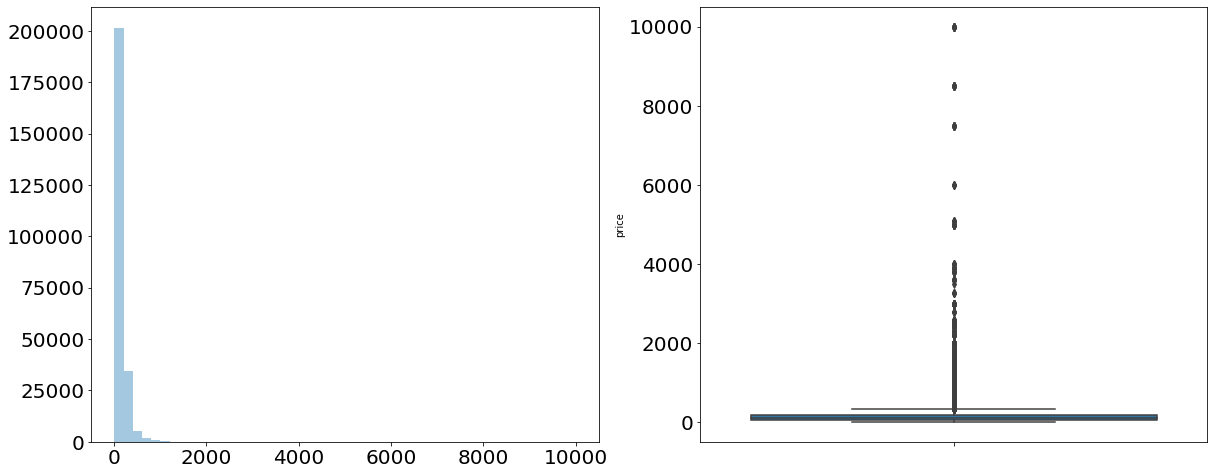

In [61]:
#Price has extreme outliers, and is very skewed
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
sns.distplot(airbnb_raw['price'], kde=False, ax=axes[0], axlabel=False)
sns.boxplot(x='price', data=airbnb_raw, orient="v",ax=axes[1])
plt.show()

In [72]:
print(airbnb_raw['price'].count())
print(airbnb_raw['price'].skew())
print(airbnb_raw['price'].mean())

244785
20.091441910997297
152.08790979839452


## Remove price outliers - IQR approach
All rows with prices exceeding  75th percentile + 3*IQR are excluded
IQR = Interquartile range

In [62]:
q1_price = np.percentile(airbnb_raw['price'], 25, interpolation='midpoint')
q3_price = np.percentile(airbnb_raw['price'], 75, interpolation='midpoint')
iqr = q3_price - q1_price
print(iqr)

110.0


In [63]:
print("Number of outliers:", airbnb_raw[airbnb_raw['price']>(3*iqr)]['price'].count())
print('New size of the dataset: ',airbnb_raw[airbnb_raw['price']<=(3*iqr)]['price'].count())
print("Old mean:", round(airbnb_raw['price'].mean(),2))
print("New mean:", round(airbnb_raw[airbnb_raw['price']<(3*iqr)]['price'].mean(),2))

Number of outliers: 15259
New size of the dataset:  229526
Old mean: 152.09
New mean: 123.34


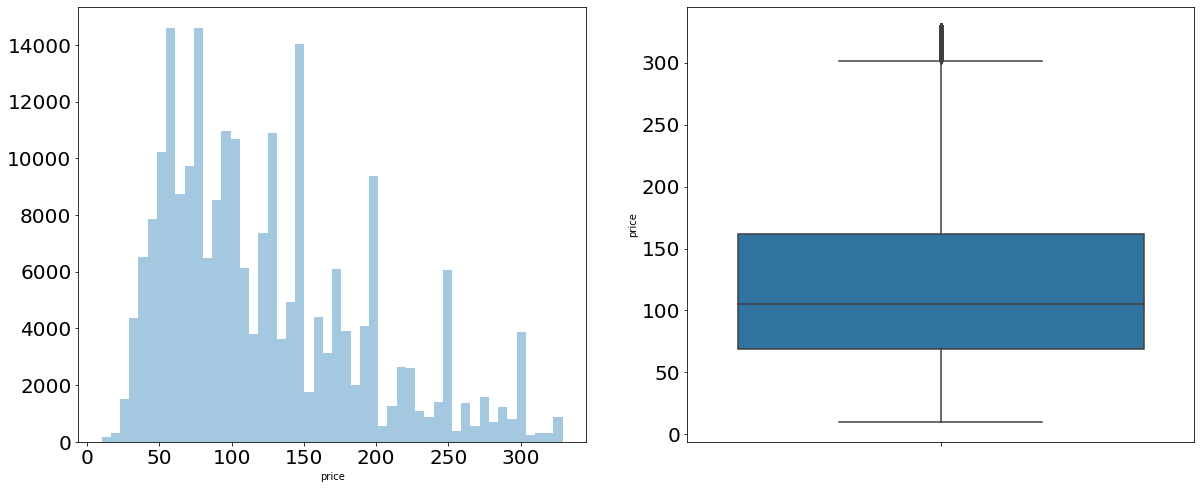

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
sns.distplot(airbnb_raw[airbnb_raw['price']<(3*iqr)]['price'], kde=False, ax=axes[0])
sns.boxplot(x='price', data=airbnb_raw[airbnb_raw['price']<(3*iqr)], orient="v",ax=axes[1])
plt.show()

## Price outliers Log transformation approach
All rows are included, price value is log transformed (used to move skewed data towards normality)

(Scientifically correct way of handling right-skewed data)

In [66]:
airbnb_raw['price'].skew()

20.091441910997297

In [67]:
np.log(airbnb_raw['price']).skew()

0.44306224965762114

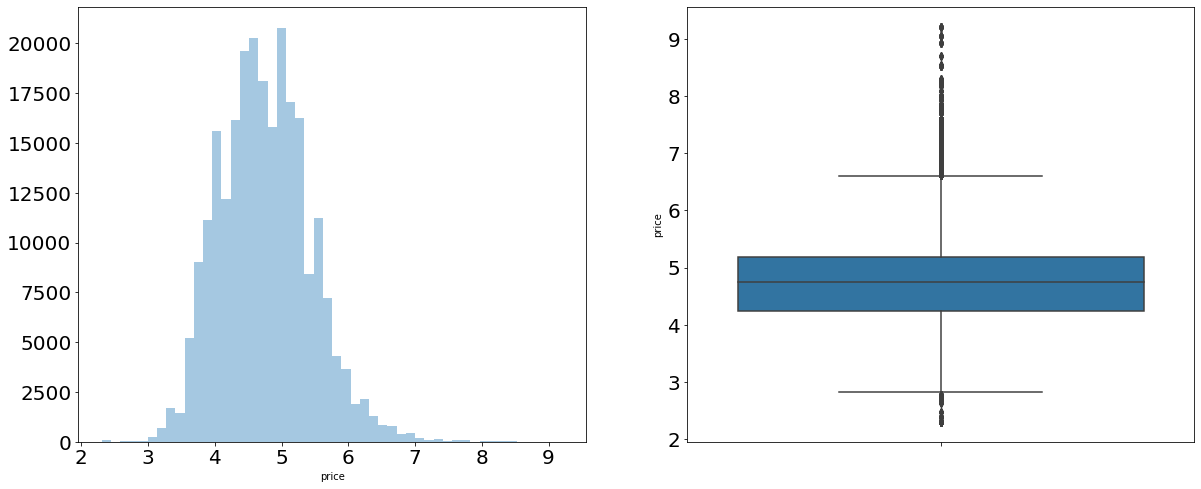

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
sns.distplot(np.log(airbnb_raw['price']), kde=False, ax=axes[0])
sns.boxplot(np.log(airbnb_raw['price']), orient="v",ax=axes[1])
plt.show()

#### It is decided to use the first method of simply removing outliers, and thus focus on the remaining listings (just abov 90% of the entire dataset)
This is because working with linear regressions on log-transformed data cannot be anti-logged

In [69]:
airbnb_final = airbnb_raw[airbnb_raw['price']<=(3*iqr)]
airbnb_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229526 entries, 0 to 244784
Data columns (total 84 columns):
listing_id                                      229526 non-null int64
host_id                                         229526 non-null int64
last_scraped                                    229526 non-null datetime64[ns]
experience                                      229526 non-null int64
host_response_rate                              229526 non-null int64
host_is_superhost                               229526 non-null int64
host_total_listings_count                       229526 non-null float64
host_identity_verified                          229526 non-null bool
calculated_host_listings_count                  229526 non-null int64
calculated_host_listings_count_entire_homes     229526 non-null int64
calculated_host_listings_count_private_rooms    229526 non-null int64
calculated_host_listings_count_shared_rooms     229526 non-null int64
neighbourhood                          

In [70]:
pd.options.display.max_columns = None
airbnb_final.head()

listing_id  host_id last_scraped  experience  host_response_rate  \
0        2539     2787   2019-01-09        3776                 100   
1        2595     2845   2019-01-09        3774                  60   
2        3330     4177   2019-01-09        3713                 100   
3        5238     7549   2019-01-09        3623                  92   
4        5295     7702   2019-01-09        3620                  92   

   host_is_superhost  host_total_listings_count  host_identity_verified  \
0                  1                        8.0                    True   
1                  0                        5.0                    True   
2                  0                        4.0                    True   
3                  1                        4.0                    True   
4                  0                        1.0                    True   

   calculated_host_listings_count  \
0                               8   
1                               2   
2                               3   
3                               4   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            0   
1                                            1   
2                                            0   
3                                            2   
4                                            1   

   calculated_host_listings_count_private_rooms  \
0                                             5   
1                                             0   
2                                             3   
3                                             0   
4                                             0   

   calculated_host_listings_count_shared_rooms    neighbourhood property_type  \
0                                            3       Kensington     Apartment   
1                                            1          Midtown     Apartment   
2                                            0     Williamsburg     Apartment   
3                                            2        Chinatown     Apartment   
4                                            0  Upper West Side     Apartment   

   bathrooms  bedrooms  beds  bed_type  amenities_count  is_wifi  is_kitchen  \
0        1.0       1.0   1.0  Real Bed               44        1           1   
1        1.0       0.0   1.0  Real Bed               36        1           1   
2        1.0       1.0   1.0  Real Bed               25        1           1   
3        1.0       1.0   2.0  Real Bed               27        1           1   
4        1.0       1.0   1.0  Real Bed               21        1           1   

   is_heating  is_smoke_detector  is_aircon  price  security_deposit  \
0           1                  1          0  149.0             100.0   
1           1                  1          1  225.0             350.0   
2           1                  1          0   70.0             150.0   
3           1                  1          1  150.0               0.0   
4           1                  1          1  135.0             450.0   

   cleaning_fee  price_for_extra_people  guests_included  minimum_nights  \
0          25.0                    25.0                1               1   
1         100.0                     0.0                2               1   
2         125.0                    50.0                2               5   
3          40.0                    10.0                2               1   
4          75.0                     0.0                1               5   

   maximum_nights  has_availability  availability_30  availability_60  \
0             730                 1               30               60   
1            1125                 1               30               60   
2             730                 1                1               10   
3            1125                 1               13               26   
4             365                 1               11               29  

In [71]:
print(airbnb_final['price'].count())
print(airbnb_final['price'].skew())
print(airbnb_final['price'].mean())

229526
0.868609629043161
123.45372637522547


## Principle Component Analysis (PCA) for accessibility measures
Since the accessibility measures are highly correlated, we are going to try to reduce the number of featues by conducting PCA (Principle Component Analysis). These all have the same unit, thus we do not necessarily have to normalize the data, which would be the traditional practice before PCA. The aim is to reduce the number of features, while maintaining the same level of information (98% of the initial variance).

First, we extract the relevant features and transpose them to fit the format for PCA. 

In [ ]:
accessibility_PCA = airbnb_final[['accesibility features','acc_2','acc_3','etc.']];
# INCLUDE INDEX
accessibility_PCA = accessibility_PCA.T
accessibility_PCA.head()

In [ ]:
from sklearn import decomposition

pca=decomposition.PCA()
pca.fit(accessibility_PCA)

Sorts and prints components depending on variance explained

In [ ]:
expl=pca.explained_variance_ratio_
expl

In [ ]:
cdf=[sum(expl[:i+1]) for i in range(len(expl))]
plt.plot(range(len(expl)), cdf);
plt.title('Figure 4: Cumulative Variance Explained')
plt.xlabel('Principal component')
plt.ylabel('Variance Explained')
cdf[:10] # printing the first 10 components ordered by explaied variance.

In [ ]:
# INCLUDE IN FINAL AIRBNB DATASET
airbnb_final['PCA_access'] = pca.components_[0]

# Preparing data for prediction

In [73]:
from sklearn.model_selection import train_test_split

#Splitting and shuffling data
prediction_data = airbnb_final.drop(['listing_id', 'host_id', 'last_scraped', 'experience', 'host_identity_verified', 'neighbourhood', 'property_type', 'bed_type', 'require_guest_profile_picture', 'require_guest_phone_verification', 'year', 'month', 'day', 'month_pad', 'yearmonth'], axis=1)
features_using = prediction_data.drop(['price'],axis=1).columns
predicting = ['price']

train, test = train_test_split(prediction_data, train_size=0.8, shuffle=True) #Test set is approx 20% of total
train, val = train_test_split(train, train_size=0.8, shuffle=True) #Validation set is approx 16% of total, train set is approx 64% of total

X_train, y_train = train[features_using], train[predicting]
X_val, y_val = val[features_using], val[predicting]
X_test, y_test = test[features_using], test[predicting]

### Function to evaluate predictions

In [74]:
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
from statistics import mean

def evaluate(y_true, y_pred):
    y_true = y_true['price'].tolist()
    print("MSE: ", round(mean_squared_error(y_true, y_pred), 4))
    print("RMSE: ", round(math.sqrt(mean_squared_error(y_true, y_pred)), 4))
    RMSE = math.sqrt(mean_squared_error(y_true, y_pred))    
    mean_y_true = mean(y_true)
    print("RRMSE: ",round(RMSE*(100/mean_y_true), 4))    
    #print("MAE: ", round(mean_absolute_error(y_true, y_pred), 4))
    print("R2: ", round(r2_score(y_true, y_pred), 4))

# Baseline calculations
1. Set avg. of training set as default prediction
2. Simple linear regression model

###### INTERPRETATION OF RRMSE: 
RMSE is stated in the same units of the original measurement, so if you are comparing distance measuring techniques, you might have an RMSE of 0.29 meters. If you're measuring mountain height or river distances then this is a tiny amount of inaccuracy, perhaps 0.005%. If you're measuring people's height, then you're about 17% off. That percentage variation in accuracy is RRMSE.

calculated by dividing the RMSE by the mean observed data

Reference: https://stats.stackexchange.com/questions/260615/what-is-the-difference-between-rrmse-and-rmsre

In [75]:
#Using plain average
y_pred = [y_train['price'].mean()] * len(y_test)
print("- Test set results:")
print("Predicted mean price:", round(y_train['price'].mean(),2))
print("Test set mean price:", round(y_test['price'].mean()),2)
evaluate(y_test, y_pred)

- Test set results:
Predicted mean price: 123.25
Test set mean price: 123 2
MSE:  4675.4848
RMSE:  68.3775
RRMSE:  55.3725
R2:  -0.0


### Multiple linear regression

In [80]:
#Predicting price with all available variables
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train.drop(['cat_neighbourhood', 'cat_property_type', 'Weather_type'],axis=1), y_train.values.ravel())

y_pred_train = lr.predict(X_train.drop(['cat_neighbourhood', 'cat_property_type', 'Weather_type'],axis=1))
y_pred_val = lr.predict(X_val.drop(['cat_neighbourhood', 'cat_property_type', 'Weather_type'],axis=1))

print("- Train set results:")
evaluate(y_train, y_pred_train)
print('\n')
print("- Validation set results:")
evaluate(y_val, y_pred_val)

- Train set results:
MSE:  1907.2085
RMSE:  43.6716
RRMSE:  35.4338
R2:  0.5908


- Validation set results:
MSE:  1968.9747
RMSE:  44.3731
RRMSE:  35.7172
R2:  0.5825


In [81]:
#Using wrapper method with backward elimination based on p-value > 0.05 for feature selection
#Reference: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
import statsmodels.api as sm

cols = list(X_train.drop(['cat_neighbourhood', 'cat_property_type', 'Weather_type'],axis=1).columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values,index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
significant_features = cols
print(significant_features)
print(len(significant_features))

C:\Users\Bruger\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['host_is_superhost', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'bathrooms', 'bedrooms', 'beds', 'amenities_count', 'is_kitchen', 'is_heating', 'is_aircon', 'security_deposit', 'cleaning_fee', 'price_for_extra_people', 'guests_included', 'minimum_nights', 'has_availability', 'availability_30', 'availability_90', 'is_instant_bookable', 'reviews_per_month', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'TDIFF_Month', 'TSNOW_Month', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'moderate', 'super_strict_60', 'within a few hours', 'within an hour', 'Private room', 'Shared room']
46


In [82]:
print("Insignificant features:")
X_train.drop(significant_features, axis=1).columns

Insignificant features:


Index(['host_response_rate', 'host_total_listings_count', 'is_wifi',
       'is_smoke_detector', 'maximum_nights', 'availability_60',
       'availability_365', 'is_business_travel_ready', 'number_of_reviews',
       'TAV', 'TAV_Month', 'TDIFF', 'Weather_type', 'holidays',
       'cat_neighbourhood', 'cat_property_type', 'cat_weather_type', 'strict',
       'strict_14_with_grace_period', 'super_strict_30', 'within a day',
       'Hotel room'],
      dtype='object')

In [83]:
#Predicting price with all significant variables SCIKIT VERSION

lr2 = LinearRegression()
lr2.fit(X_train[significant_features], y_train.values.ravel())

y_pred_train2 = lr2.predict(X_train[significant_features])
y_pred_val2 = lr2.predict(X_val[significant_features])
y_pred_test2 = lr2.predict(X_test[significant_features])

print("- Train set results:")
evaluate(y_train, y_pred_train2)
print('\n')
print("- Validation set results:")
evaluate(y_val, y_pred_val2)
print('\n')
print("- Test set results:")
evaluate(y_test, y_pred_test2)

- Train set results:
MSE:  1907.4608
RMSE:  43.6745
RRMSE:  35.4362
R2:  0.5907


- Validation set results:
MSE:  1969.6778
RMSE:  44.3811
RRMSE:  35.7236
R2:  0.5823


- Test set results:
MSE:  1896.2857
RMSE:  43.5464
RRMSE:  35.2641
R2:  0.5944


In [85]:
#Predicting price with all significant variables STATSMODEL VERSION

X_1 = X_train[significant_features]
X_1 = sm.add_constant(X_1)
model2 = sm.OLS(y_train,X_1).fit()

#lr2 = LinearRegression()
#lr2.fit(X_train[significant_features], y_train.values.ravel())

y_pred_train2 = model2.predict(X_train[significant_features])
y_pred_test2 = model2.predict(X_test[significant_features])

print("- Train set results:")
evaluate(y_train, y_pred_train2)
print('\n')
print("- Test set results:")
evaluate(y_test, y_pred_test2)

C:\Users\Bruger\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


- Train set results:
MSE:  1907.4608
RMSE:  43.6745
RRMSE:  35.4362
R2:  0.5907


- Test set results:
MSE:  1896.2857
RMSE:  43.5464
RRMSE:  35.2641
R2:  0.5944


In [86]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     4818.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:05:29   Log-Likelihood:            -7.6323e+05
No. Observations:              146896   AIC:                         1.527e+06
Df Residuals:                  146851   BIC:                         1.527e+06
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
host_is_superhost                                2.8705      0.272     10.555      0.000       2.338       3.404
calculated_host_listings_count                   0.4349      0.132      3.305      0.001       0.177       0.693
calculated_host_listings_count_entire_homes     -0.3634      0.132     -2.754      0.006      -0.622      -0.105
calculated_host_listings_count_private_rooms    -0.4276      0.133     -3.216      0.001      -0.688      -0.167
calculated_host_listings_count_shared_rooms     -1.6812      0.175     -9.587      0.000      -2.025      -1.337
bathrooms                                        5.5133      0.300     18.365      0.000       4.925       6.102
bedrooms                                        16.5021      0.218     75.817      0.000      16.076      16.929
beds                                             2.7271      0.145     18.838      0.000       2.443       3.011
amenities_count                                  0.1327      0.013     10.167      0.000       0.107       0.158
is_kitchen                                       1.1119      0.414      2.687      0.007       0.301       1.923
is_heating                                      -2.9446      0.680     -4.329      0.000      -4.278      -1.612
is_aircon                                       11.4787      0.383     29.960      0.000      10.728      12.230
security_deposit                                 0.0019      0.000      6.482      0.000       0.001       0.003
cleaning_fee                                     0.1692      0.003     55.385      0.000       0.163       0.175
price_for_extra_people                           0.0315      0.005      6.725      0.000       0.022       0.041
guests_included                                  6.1218      0.121     50.596      0.000       5.885       6.359
minimum_nights                                  -0.4359      0.008    -55.248      0.000      -0.451      -0.420
has_availability                               -24.8525      2.162    -11.493      0.000     -29.091     -20.614
availability_30                                  0.3543      0.020     17.829      0.000       0.315       0.393
availability_90                                  0.0299      0.007      4.586      0.000       0.017       0.043
is_instant_bookable                              0.9978      0.253      3.949      0.000       0.503       1.493
reviews_per_month                               -0.2632      0.110     -2.394      0.017      -0.479      -0.048
number_of_reviews_ltm                           -0.1566      0.010    -15.523      0.000      -0.176      -0.137
review_scores_rating                             0.6177      0.031     19.905      0.000       0.557       0.679
review_scores_accuracy          

# Random forest

In [338]:
# Randomized search for best params using cross validation
# Reference: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Hyper parameter tuning: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Create the parameter grid search lists
param_grid = {
    'max_features': list(range(2,len(features_using),15)),
    'max_depth': list(range(2,len(features_using),15)),
    'n_estimators': [200, 300, 500],
    'min_samples_leaf': list(range(5,100,30))
}

rf2 = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = param_grid, n_iter = 50, cv = 3, verbose=1, n_jobs = -1)
rf_random.fit(X_train, y_train.values.ravel())
rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 48.5min finished


{'n_estimators': 90, 'max_features': 62, 'max_depth': 65}

In [339]:
print("tuned hyperparameters :",rf_random.best_params_)
print("accuracy :",rf_random.best_score_)

tuned hyperparameters : {'n_estimators': 90, 'max_features': 62, 'max_depth': 65}
accuracy : 0.8991724113606752


In [343]:
from sklearn.ensemble import RandomForestRegressor

rf3 = RandomForestRegressor(n_estimators=300, max_features=32, min_samples_leaf=100, max_depth=50, random_state = 42)
rf3.fit(X_train, y_train.values.ravel())

y_pred_train = rf3.predict(X_train)
y_pred_test = rf3.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print('\n')
print("- Test set results:")
evaluate(y_test, y_pred_test)

- Train set results:
MSE:  48.5167
RMSE:  6.9654
MAE:  3.7894
R2:  0.9896


- Test set results:
MSE:  327.1223
RMSE:  18.0865
MAE:  9.9717
R2:  0.9304


In [ ]:
# Get numerical feature importances
importances = list(rf3.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_using, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

In [296]:
#Random forest should not be as sensitive to outliers, thus we have not used log price
from sklearn.model_selection import GridSearchCV

# Create the parameter grid search lists
param_grid = {
    'max_features': list(range(2,len(features_using),15)),
    'max_depth': list(range(5,105,20)),
    'n_estimators': [100, 200, 300, 1000],
    'min_samples_leaf': np.linspace(0.01, 0.1, 5, endpoint=True)
}
# Create the model
rf = RandomForestRegressor(random_state = 42)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose = 1, n_jobs = -1)
grid_search.fit(X_train, y_train.values.ravel())
grid_search.best_estimator_

Fitting 3 folds for each of 153 candidates, totalling 459 fits


C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

KeyboardInterrupt: 

In [ ]:
print("tuned hyperparameters :",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

In [69]:
rf4 = RandomForestRegressor(max_features=32, max_depth=25, min_samples_leaf=0.05, n_estimators=1000, random_state = 42)
rf4.fit(X_train, y_train.values.ravel())

y_pred_train = rf4.predict(X_train)
y_pred_test = rf4.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print('\n')
print("- Test set results:")
evaluate(y_test, y_pred_test)

C:\Users\Bruger\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


- Train set results:
MSE:  22970.2513
RMSE:  151.5594
MAE:  51.2003
R2:  0.3257


- Test set results:
MSE:  34849.8277
RMSE:  186.6811
MAE:  54.0266
R2:  0.2351


In [41]:
# Get numerical feature importances
importances = list(rf4.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_using, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: cleaning_fee         Importance: 0.18
Variable: host_total_listings_count Importance: 0.08
Variable: bedrooms             Importance: 0.07
Variable: cat_neighbourhood    Importance: 0.05
Variable: bathrooms            Importance: 0.05
Variable: beds                 Importance: 0.05
Variable: security_deposit     Importance: 0.05
Variable: guests_included      Importance: 0.05
Variable: cat_borough          Importance: 0.04
Variable: cat_room_type        Importance: 0.04
Variable: amenities_count      Importance: 0.04
Variable: cat_property_type    Importance: 0.03
Variable: price_for_extra_people Importance: 0.03
Variable: minimum_nights       Importance: 0.03
Variable: maximum_nights       Importance: 0.03
Variable: number_of_reviews_ltm Importance: 0.03
Variable: review_scores_rating Importance: 0.02
Variable: review_scores_location Importance: 0.02
Variable: host_response_rate   Importance: 0.01
Variable: is_kitchen           Importance: 0.01
Variable: is_smoke_detector   

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### XGBOOST

[07:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
- Train set results:
MSE:  16126.8082
RMSE:  126.9914
MAE:  47.1625
R2:  0.5266


- Test set results:
MSE:  25769.5199
RMSE:  160.5289
MAE:  48.6094
R2:  0.4344


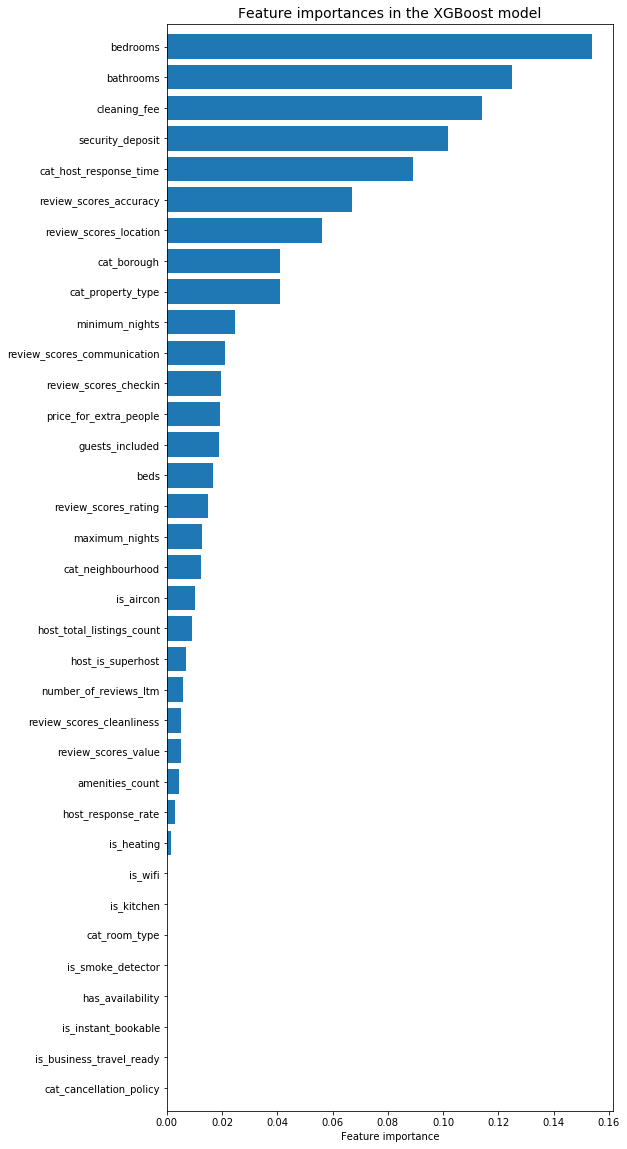

In [70]:
import xgboost as xgb

# Fitting the model
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results
#print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("- Train set results:")
evaluate(y_train, training_preds_xgb_reg)
print('\n')
print("- Test set results:")
evaluate(y_test, val_preds_xgb_reg)

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()